<a href="https://colab.research.google.com/github/Okocha76/Okocha76.github.io/blob/master/Migration_In_Europe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Migration In Europe

---

## Import Data

In [0]:
%%capture
import sys

!pip install category_encoders==2.*
!pip install pdpbox
!pip install shap

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [0]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Okocha76/migration-in-europe/master/euro_mig_data_imputed.csv', sep=';', engine='python', encoding = "ISO-8859-1")

In [3]:
print(df.shape)
df.head(5)

(7342, 22)


,TIME,GEO,GEO_LABEL,MED_AGE_MOTHER,TOT_FER_RT,NET_MIGRAT_RT,BIRTH_RT,DEATH_RT,INF_MORT_RT,GDP_HAB_INDEX,EDU_LOW,EDU_HIGH,MED_AGE_MOTHER_DIFF,TOT_FER_RT_DIFF,NET_MIGRAT_RT_DIFF,BIRTH_RT_DIFF,DEATH_RT_DIFF,INF_MORT_RT_DIFF,GDP_HAB_INDEX_DIFF,EDU_LOW_DIFF,EDU_HIGH_DIFF,MIG_CHANGE
0,2000,AT,Austria,29.4,1.35,2.2,9.8,9.6,4.8,134.0,16.7,15.9,0.0,0.00,0.0,0.0,0.0,0.0,0,0.0,0.0,Y2K
1,2001,AT,Austria,29.6,1.31,5.2,9.4,9.3,4.8,133.0,16.0,16.1,0.2,-0.04,3.0,-0.4,-0.3,0.0,-1,-0.7,0.2,LOWER
2,2002,AT,Austria,29.8,1.38,4.3,9.7,9.4,4.1,132.0,15.9,17.2,0.2,0.07,-0.9,0.3,0.1,-0.7,-1,-0.1,1.1,HIGHER
3,2003,AT,Austria,29.9,1.36,5.2,9.5,9.5,4.5,132.0,14.3,17.6,0.1,-0.02,0.9,-0.2,0.1,0.4,0,-1.6,0.4,HIGHER
4,2004,AT,Austria,29.5,1.42,6.6,9.7,9.1,4.5,132.0,13.5,20.9,-0.4,0.06,1.4,0.2,-0.4,0.0,0,-0.8,3.3,LOWER


In [4]:
train = df[(df['TIME'] >= 2001) & (df['TIME'] <= 2012)]
val = df[(df['TIME'] >= 2013) & (df['TIME'] < 2016)]
test = df[df['TIME'] == 2016]

train.shape, val.shape, test.shape

((4784, 22), (1307, 22), (436, 22))

In [0]:
import numpy as np

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()

    X['TIME'] = X['TIME'].astype('category')

    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['MED_AGE_MOTHER', 'TOT_FER_RT', 'NET_MIGRAT_RT', 
                       'BIRTH_RT', 'DEATH_RT', 'INF_MORT_RT',	'GDP_HAB_INDEX',
                       'EDU_LOW',	'EDU_HIGH']

    for col in cols_with_zeros:
      X[col] = X[col].replace(0, np.nan)

    X = X.replace("NAN", np.nan)

    # Cast columns to float.
    cols_2_num = ['MED_AGE_MOTHER_DIFF', 'TOT_FER_RT_DIFF', 'NET_MIGRAT_RT_DIFF', 
                       'BIRTH_RT_DIFF', 'DEATH_RT_DIFF', 'INF_MORT_RT_DIFF',	
                       'GDP_HAB_INDEX_DIFF', 'EDU_LOW_DIFF',	'EDU_HIGH_DIFF']

    for col in cols_2_num:
      X[col] = X[col].astype('float')

    X['MIG_CHANGE'] = X['MIG_CHANGE'].replace("HIGHER", "UP")
    X['MIG_CHANGE'] = X['MIG_CHANGE'].replace("LOWER", "DOWN")    
    
    # return the wrangled dataframe
    return X


train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [6]:
print(train.shape)
train.sample(5)

(4784, 22)


,TIME,GEO,GEO_LABEL,MED_AGE_MOTHER,TOT_FER_RT,NET_MIGRAT_RT,BIRTH_RT,DEATH_RT,INF_MORT_RT,GDP_HAB_INDEX,EDU_LOW,EDU_HIGH,MED_AGE_MOTHER_DIFF,TOT_FER_RT_DIFF,NET_MIGRAT_RT_DIFF,BIRTH_RT_DIFF,DEATH_RT_DIFF,INF_MORT_RT_DIFF,GDP_HAB_INDEX_DIFF,EDU_LOW_DIFF,EDU_HIGH_DIFF,MIG_CHANGE
6186,2010,TR33,"Manisa, Afyonkarahisar, Kütahya, Usak",26.2,1.76,14.2,14.0,6.4,13.4,25.0,65.0,13.6,0.4,-0.02,12.8,-0.4,-0.3,-2.7,4.0,-7.5,3.3,DOWN
6950,2002,UKH3,Essex,30.1,1.69,4.5,11.0,10.2,4.9,126.0,32.1,20.6,0.1,0.02,-0.1,0.0,0.1,1.0,-1.0,-4.4,-0.3,DOWN
2583,2012,ES41,Castilla y León,33.5,1.17,-3.9,7.5,11.2,2.7,79.0,31.1,44.1,0.1,-0.02,-3.7,-0.3,0.5,-1.0,-4.0,0.2,-3.6,DOWN
6126,2010,TR2,Bati Marmara,27.1,1.52,6.7,11.5,7.3,10.4,33.0,61.7,13.4,0.2,-0.02,3.9,-0.2,0.0,-3.0,6.0,-0.3,1.8,UP
1465,2007,DE93,Lüneburg,30.4,1.48,1.1,8.1,10.3,3.8,81.0,14.6,15.0,0.1,0.02,-0.4,0.0,0.0,-0.8,0.0,-1.5,-1.9,DOWN


In [0]:
# Generate Pandas Profiling Report and export to html

# from pandas_profiling import ProfileReport

# profile = ProfileReport(train, title='Pandas Profiling Report')

# profile.to_file(output_file="your_report.html")

## Baseline

In [8]:
y = train['MIG_CHANGE']
y.value_counts(normalize=True)

DOWN    0.514005
UP      0.485995
Name: MIG_CHANGE, dtype: float64

Baseline prediction: majority class (DOWN) occurs with 51.4% frequency.

## Model

In [0]:
# Arrange data into X features matrix and y target vector
target = 'MIG_CHANGE'
features = train.columns.drop([target, 'GEO_LABEL'])

X_train = train[features]
X_val = val[features]
X_test = test[features]

y_train = train[target]
y_val = val[target]
y_test = test[target]

## Logistic Regression

In [10]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    # ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on val
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on test
y_pred = pipeline.predict(X_test)

Validation Accuracy 0.5692425401683244


## Random Forest

In [11]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.5562356541698547


## Feature Importances

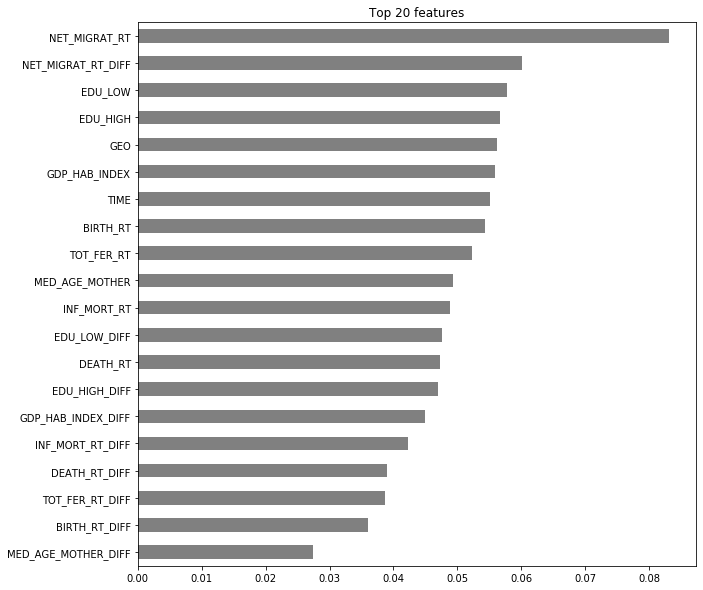

In [12]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

## Drop-Column Importance

In [13]:
column  = 'NET_MIGRAT_RT'

# Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Fit with column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train)
score_with = pipeline.score(X_val, y_val)
print(f'Validation Accuracy with {column}: {score_with}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without NET_MIGRAT_RT: 0.5164498852333589
Validation Accuracy with NET_MIGRAT_RT: 0.5562356541698547
Drop-Column Importance for NET_MIGRAT_RT: 0.03978576893649577


In [14]:
column  = 'TIME'

# Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without TIME: 0.5470543228768171
Drop-Column Importance for TIME: 0.009181331293037553


In [15]:
column  = 'GEO'

# Fit without column
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)
pipeline.fit(X_train.drop(columns=column), y_train)
score_without = pipeline.score(X_val.drop(columns=column), y_val)
print(f'Validation Accuracy without {column}: {score_without}')

# Compare the error with & without column
print(f'Drop-Column Importance for {column}: {score_with - score_without}')

Validation Accuracy without GEO: 0.5531752104055088
Drop-Column Importance for GEO: 0.003060443764345888


## Permutation Importance

In [0]:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

In [17]:
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [18]:
!pip install eli5

In [19]:
import eli5
from eli5.sklearn import PermutationImportance

# 1. Calculate permutation importances
permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [20]:
feature_names = X_val.columns.tolist()
# pd.Series(permuter.feature_importances_, feature_names).sort_values()

# 2. Display permutation importances
eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names # must be a list
)

Weight,Feature
0.0386 ± 0.0254,NET_MIGRAT_RT
0.0291 ± 0.0144,GDP_HAB_INDEX
0.0096 ± 0.0219,NET_MIGRAT_RT_DIFF
0.0038 ± 0.0085,INF_MORT_RT
0.0035 ± 0.0110,TOT_FER_RT
0.0014 ± 0.0137,DEATH_RT_DIFF
0.0014 ± 0.0051,TOT_FER_RT_DIFF
0.0002 ± 0.0120,EDU_HIGH
0 ± 0.0000,TIME
-0.0005 ± 0.0075,MED_AGE_MOTHER_DIFF


## Feature selection

In [0]:
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]

In [22]:
X_val = X_val[features]
X_test = X_test[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.5845447589900535


In [23]:
permuter.feature_importances_ - permuter.feature_importances_std_ > 0

array([False, False, False, False,  True, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False])

## Gradient Boosting

In [24]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=[], drop_invariant=False,
                                handle_missing='value', handle_unknown='value',
                                mapping=[], return_df=True, verbose=0)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=None,
                               n_estimators=100, n_jobs=-1, nthread=None,
                               objective='binary:logistic', random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               seed=None, silent=None, subsample=1,
                               verbosity=1))],
      

In [25]:
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.6143840856924254


In [26]:
# fit_transfom on train, transform on val
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

model = XGBClassifier(
    n_estimators=1000,  
    max_depth=3,       
    learning_rate=0.14,  
    min_child_weight=0.2,  
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train), 
            (X_val_encoded, y_val)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set,
          eval_metric='error', 
          early_stopping_rounds=50) 

[0]	validation_0-error:0.400084	validation_1-error:0.463657
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.388587	validation_1-error:0.422341
[2]	validation_0-error:0.381062	validation_1-error:0.377965
[3]	validation_0-error:0.375	validation_1-error:0.379495
[4]	validation_0-error:0.375836	validation_1-error:0.372609
[5]	validation_0-error:0.369774	validation_1-error:0.372609
[6]	validation_0-error:0.369774	validation_1-error:0.368018
[7]	validation_0-error:0.371446	validation_1-error:0.368018
[8]	validation_0-error:0.369774	validation_1-error:0.370314
[9]	validation_0-error:0.367266	validation_1-error:0.364958
[10]	validation_0-error:0.365176	validation_1-error:0.373374
[11]	validation_0-error:0.36413	validation_1-error:0.367253
[12]	validation_0-error:0.363294	validation_1-error:0.374139
[13]	validation_0-error:0.361622	validation_1-error:0.369549

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.14, max_delta_step=0, max_depth=3,
              min_child_weight=0.2, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

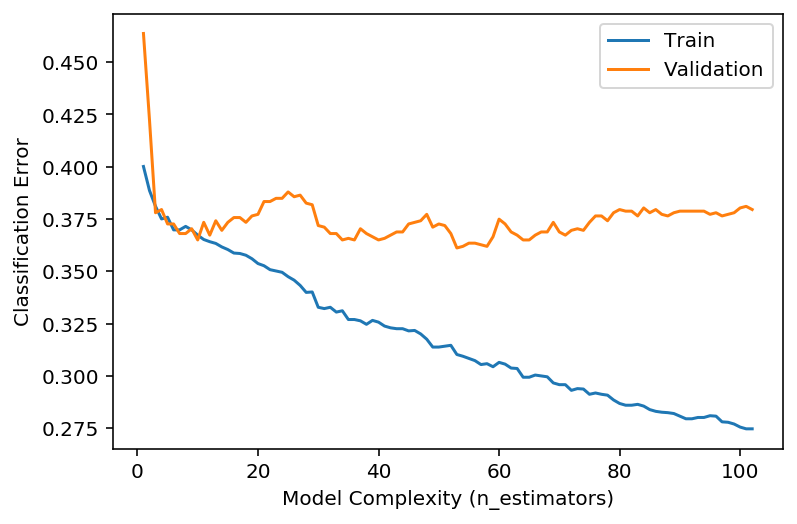

In [27]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

results = model.evals_result()
train_error = results['validation_0']['error']
val_error = results['validation_1']['error']
epoch = range(1, len(train_error)+1)
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.legend();

## Partial Dependence Plot

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'NET_MIGRAT_RT'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

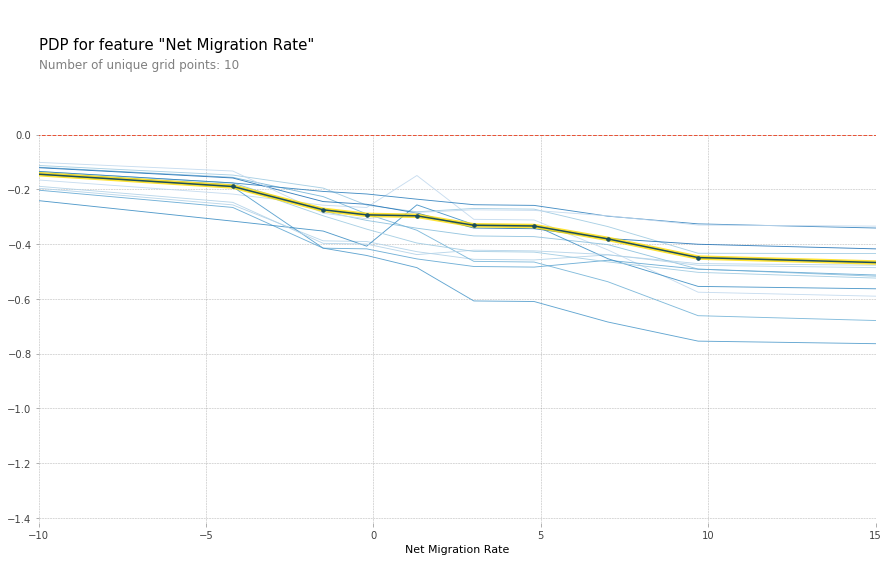

In [43]:
plt.rcParams['figure.dpi'] = 72
pdp_plot(isolated, feature_name='Net Migration Rate', plot_lines=True, 
         frac_to_plot=0.01)
plt.xlim((-10,15));

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


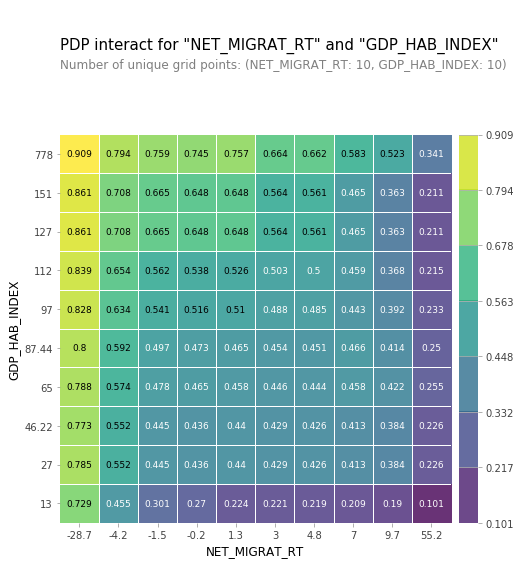

In [31]:
features = ['NET_MIGRAT_RT', 'GDP_HAB_INDEX']

interaction = pdp_interact(
    model=pipeline, 
    dataset=X_val,
    model_features=X_val.columns, 
    features=features
)

pdp = pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features)

plt.grid(None)

#                   ,plot_params={'cmap':'viridis'})
# plt.grid('off')

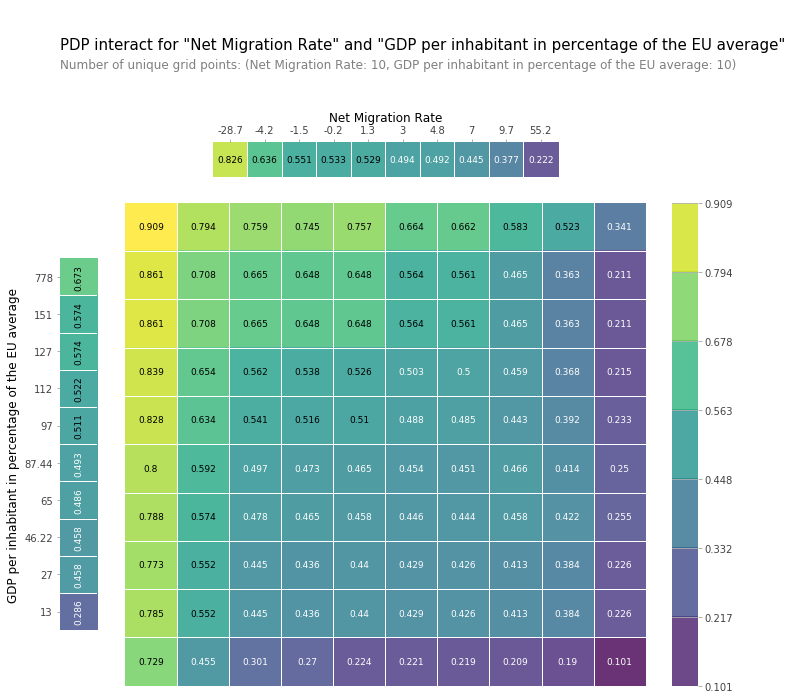

In [32]:
# Trying to get rid of these annoying white gridlines.

from pdpbox import pdp

interaction = pdp.pdp_interact(
    model=pipeline, 
    dataset=X_val,
    model_features=X_val.columns, 
    features = ['NET_MIGRAT_RT', 'GDP_HAB_INDEX'])

fig, axes = pdp.pdp_interact_plot(
    pdp_interact_out=interaction, feature_names=['Net Migration Rate', 'GDP per inhabitant in percentage of the EU average'],
    plot_type='grid',x_quantile=False, plot_pdp=True)

plt.grid(None)

In [33]:
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1]

# Remove outliers
pdp = pdp.drop(columns=[-28.7, 55.2])
pdp = pdp.iloc[1:9]

pdp

NET_MIGRAT_RT,-4.2,-1.5,-0.2,1.3,3.0,4.8,7.0,9.7
GDP_HAB_INDEX,,,,,,,,
151.000000,0.707626,0.664582,0.648064,0.648273,0.563674,0.561066,0.465328,0.363149
127.000000,0.707626,0.664582,0.648064,0.648273,0.563674,0.561066,0.465328,0.363149
112.000000,0.653927,0.562317,0.537814,0.525629,0.503110,0.500471,0.458992,0.368276
97.000000,0.634332,0.540848,0.515981,0.510140,0.487544,0.484882,0.443106,0.392283
87.444444,0.592386,0.497442,0.472582,0.465486,0.454066,0.451412,0.465686,0.414432
65.000000,0.573878,0.478340,0.464980,0.457698,0.446290,0.443633,0.457914,0.422112
46.222222,0.552309,0.444928,0.435647,0.440223,0.428845,0.426189,0.412837,0.383739
27.000000,0.552309,0.444928,0.435647,0.440223,0.428845,0.426189,0.412837,0.383739


In [34]:
import plotly
import plotly.graph_objs as go

surface = go.Surface(
    x=pdp.columns, 
    y=pdp.index, 
    z=pdp.values
)

layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title=target)
    )
)

fig = go.Figure(surface, layout)
fig.show()
plotly.offline.plot(fig, filename='3d-pdp.html')

'3d-pdp.html'

## Shapley Value Plots

In [35]:
row = X_test.iloc[[374]]
row

,TOT_FER_RT,NET_MIGRAT_RT,INF_MORT_RT,GDP_HAB_INDEX,EDU_HIGH,TOT_FER_RT_DIFF,NET_MIGRAT_RT_DIFF,DEATH_RT_DIFF
6382,1.76,22.7,7.2,23.0,27.3,-0.01,25.9,0.1


In [36]:
!pip install shap

In [37]:
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder()
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, max_depth=3, learning_rate=0.14,  
          min_child_weight=0.2,n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='error', 
          early_stopping_rounds=50)

[0]	validation_0-error:0.400084	validation_1-error:0.463657
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.388587	validation_1-error:0.422341
[2]	validation_0-error:0.381062	validation_1-error:0.377965
[3]	validation_0-error:0.375	validation_1-error:0.379495
[4]	validation_0-error:0.375836	validation_1-error:0.372609
[5]	validation_0-error:0.369774	validation_1-error:0.372609
[6]	validation_0-error:0.369774	validation_1-error:0.368018
[7]	validation_0-error:0.371446	validation_1-error:0.368018
[8]	validation_0-error:0.369774	validation_1-error:0.370314
[9]	validation_0-error:0.367266	validation_1-error:0.364958
[10]	validation_0-error:0.365176	validation_1-error:0.373374
[11]	validation_0-error:0.36413	validation_1-error:0.367253
[12]	validation_0-error:0.363294	validation_1-error:0.374139
[13]	validation_0-error:0.361622	validation_1-error:0.369549

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.14, max_delta_step=0, max_depth=3,
              min_child_weight=0.2, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [38]:
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row, 
    link='logit' # For classification, this shows predicted probabilities
)

In [39]:
def explain(row_number):
    positive_class = 'UP'
    positive_class_index = 1

    # Get & process the data for the row
    row = X_test.iloc[[row_number]]
    row_processed = processor.transform(row)

    # Make predictions (includes predicted probability)
    pred = model.predict(row_processed)[0]
    pred_proba = model.predict_proba(row_processed)[0, positive_class_index]
    pred_proba *= 100
    if pred != positive_class:
        pred_proba = 100 - pred_proba

    # Show prediction & probability
    print(f'The model predicts net migration in 2017 will be {pred} compared to 2016 with {pred_proba:.0f}% probability.')
    
    # Get shapley additive explanations
    shap_values = explainer.shap_values(row_processed)

    # Get top 3 "pros & cons" for fully paid
    feature_names = row.columns
    feature_values = row.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    pros = shaps.sort_values(ascending=False)[:3].index
    cons = shaps.sort_values(ascending=True)[:3].index

    # Show top 3 reason for prediction
    print('\n')
    print('Top 3 reasons for prediction:')
    evidence = pros if pred == positive_class else cons
    for i, info in enumerate(evidence, start=1):
        feature_name, feature_value = info
        print(f'{i}. {feature_name} is {feature_value}.')

    # Show top 1 counter-argument against prediction
    print('\n')
    print('Top counter-argument against prediction:')
    evidence = cons if pred == positive_class else pros
    feature_name, feature_value = evidence[0]
    print(f'- {feature_name} is {feature_value}.')

    # Show Shapley Values Force Plot
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value, 
        shap_values=shap_values, 
        features=row, 
        link='logit' # For classification, this shows predicted probabilities
    )

explain(374)

The model predicts net migration in 2017 will be DOWN compared to 2016 with 90% probability.


Top 3 reasons for prediction:
1. NET_MIGRAT_RT is 22.7.
2. NET_MIGRAT_RT_DIFF is 25.9.
3. GDP_HAB_INDEX is 23.0.


Top counter-argument against prediction:
- EDU_HIGH is 27.3.


In [40]:
row = X_test.iloc[[374]]
row

feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
shaps

(TOT_FER_RT, 1.76)            0.008364
(NET_MIGRAT_RT, 22.7)        -1.326557
(INF_MORT_RT, 7.2)           -0.099793
(GDP_HAB_INDEX, 23.0)        -0.191748
(EDU_HIGH, 27.3)              0.014766
(TOT_FER_RT_DIFF, -0.01)     -0.016060
(NET_MIGRAT_RT_DIFF, 25.9)   -0.478423
(DEATH_RT_DIFF, 0.1)         -0.008936
dtype: float32

## Logistic Regression

In [41]:
pipeline = make_pipeline(
    # ce.OneHotEncoder(use_cat_names=True),
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    LogisticRegression(multi_class='auto', solver='lbfgs', n_jobs=-1)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on val
print('Validation Accuracy', pipeline.score(X_val, y_val))

# Predict on test
y_pred = pipeline.predict(X_test)

Validation Accuracy 0.595256312165264


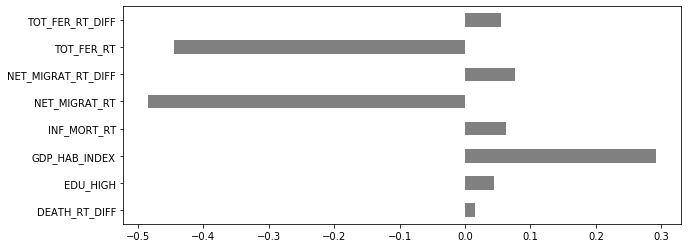

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt

model = pipeline.named_steps['logisticregression']
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
coefficients = pd.Series(model.coef_[0], encoded_columns)
plt.figure(figsize=(10,4))
coefficients.sort_index().plot.barh(color='grey');